In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import astropy.units as u
from astropy.table import Table

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

In [2]:
hostname = "LHS 1478"

In [3]:
sectors = lk.search_lightcurve(hostname, author='SPOC')

In [4]:
sectors

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,SPOC,120,396562848,0.0
1,TESS Sector 19,2019,SPOC,120,396562848,0.0
2,TESS Sector 25,2020,SPOC,120,396562848,0.0
3,TESS Sector 26,2020,SPOC,120,396562848,0.0
4,TESS Sector 52,2022,SPOC,120,396562848,0.0
5,TESS Sector 53,2022,SPOC,120,396562848,0.0
6,TESS Sector 59,2022,SPOC,20,396562848,0.0
7,TESS Sector 59,2022,SPOC,120,396562848,0.0


In [5]:
sector_numbers = []
for sector in sectors.mission: sector_numbers.append(int(sector[-2:]))
sector_numbers = np.array(sector_numbers)
np.argwhere(sector_numbers==62).shape[0]
sectors.exptime[0].value == 120

True

In [6]:
times, fluxes, texps = [], [], []
for i, secnum in enumerate(sector_numbers): 
    nsectors = np.argwhere(sector_numbers==secnum).shape[0]
    # kludgey way to get high cadence data if it exists, otherwise just normal data
    if nsectors == 1: lc_file = lk.search_lightcurve(hostname, sector=secnum,
                                   author="SPOC"
                                  ).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
    else: 
        if sectors.exptime[i].value == 120: continue
        else: lc_file = lk.search_lightcurve(hostname, sector=secnum,
                                   author="SPOC"
                                  ).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
    lc = lc_file.remove_nans().normalize().remove_outliers()
    time = lc.time.value
    flux = lc.flux
    
    with fits.open(lc_file.filename) as hdu: hdr = hdu[1].header

    texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
    texp /= 60.0 * 60.0 * 24.0

    times.append(time)
    fluxes.append(flux)
    texps.append(texp) # seconds

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [10]:
times

[array([1790.65937061, 1790.66075954, 1790.66214847, ..., 1813.97230532,
        1813.97369422, 1813.97508312]),
 array([1816.08760151, 1816.08899041, 1816.09037931, ..., 1841.10132647,
        1841.10271534, 1841.1041042 ]),
 array([1983.62987678, 1983.63126564, 1983.6326545 , ..., 2009.29912432,
        2009.30051322, 2009.30190212]),
 array([2011.12135866, 2011.12274755, 2011.12413645, ..., 2035.12870175,
        2035.13009068, 2035.13147961]),
 array([2718.63222894, 2718.63361781, 2718.63500667, ..., 2743.06963358,
        2743.07102248, 2743.07241137]),
 array([2743.99324873, 2743.99463763, 2743.99602652, ..., 2768.97289654,
        2768.97428547, 2768.97567439]),
 array([2911.77654707, 2911.77677856, 2911.77701004, ..., 2936.69051416,
        2936.69074564, 2936.69097712])]

In [11]:
#time = np.hstack(times)
#flux = np.hstack(fluxes)
sector_ind = 6
sector_ind_start, sector_ind_end = 0, 6
time = np.hstack(times[sector_ind_start:sector_ind_end])
flux = np.hstack(fluxes[sector_ind_start:sector_ind_end])
texp = texps[sector_ind]

0.0002314814814814815

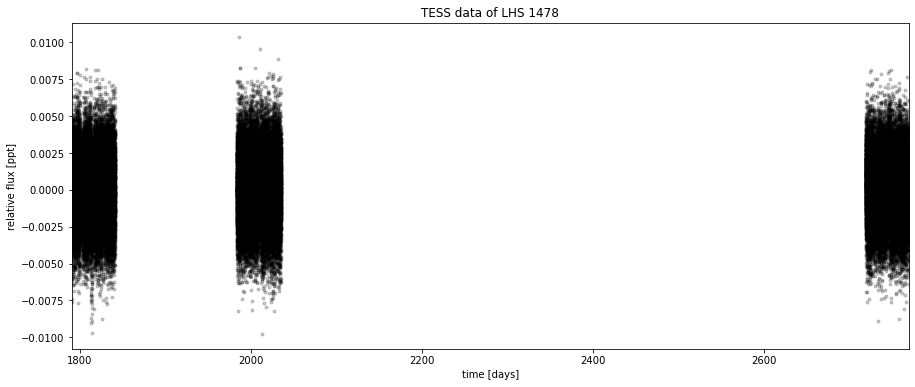

In [12]:
ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(flux - 1.0, dtype=np.float64)

%matplotlib inline
plt.figure(figsize=(15, 6))
plt.title(f'TESS data of {hostname}')
plt.plot(x, y, ".k", alpha=0.2)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

texp

(1790.6593706052263, 2768.9756743937514)

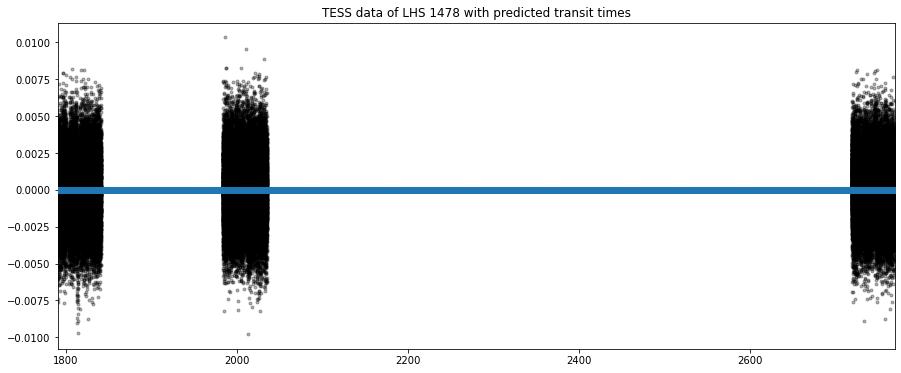

In [13]:
# priors
T0        = 2458786.75425-2457000
T0_unc    = 0.00042
P         = 1.9495378
P_unc     = 0.0000041
Rp_Rs     = 0.0462
Rp_Rs_unc = 0.0011
depth     = Rp_Rs**2
depth_unc = 2*Rp_Rs*Rp_Rs_unc
Rs        = 0.246
Rs_unc    = 0.008
Ms        = 0.236
Ms_unc    = 0.012
R_pl      = (Rp_Rs * Rs*u.R_sun).to(u.R_earth).value

%matplotlib inline
plt.figure(figsize=(15, 6))
plt.title(f'TESS data of {hostname} with predicted transit times')
plt.plot(x, y, 'k.', alpha=0.3)
n = np.arange(0, 1000)
t = T0 + n*P
plt.plot(t, [0 for i in t], 'o', color='C0', zorder=1000)
plt.xlim(x[0], x[-1])

In [14]:
phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=0.001)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters
        M_star = Ms, Ms_unc
        R_star = Rs, Rs_unc
        #BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=0.5)
        #m_star = BoundedNormal(
        #    "m_star", mu=M_star[0], sd=M_star[1]
        #)
        #r_star = BoundedNormal(
        #    "r_star", mu=R_star[0], sd=R_star[1]
        #)
        m_star, r_star = M_star[0], R_star[0]

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=T0, sd=T0_unc)
        log_period = pm.Normal("log_period", mu=np.log(P), sd=P_unc)
        period = pm.Deterministic("period", tt.exp(log_period))
        
        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(depth), sigma=depth_unc)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)
        
        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=0.1
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=0.01)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=0.1
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.Matern32Term(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        #map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        #map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


In [15]:
%matplotlib inline
model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: 468066.58109630726 -> 468155.038826591
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 468155.038826591 -> 468200.8025083759
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 468200.80250837584 -> 468205.0717295431
optimizing logp for variables: [u_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 468205.0717295431 -> 468205.6148198666
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 468205.6148198666 -> 468205.910890438
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: 468205.910890438 -> 468206.50188944885
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 468206.5018894489 -> 468206.54292055813
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: 468206.54292055813 -> 468206.5698016308
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 468206.56980163074 -> 468207.4062396958


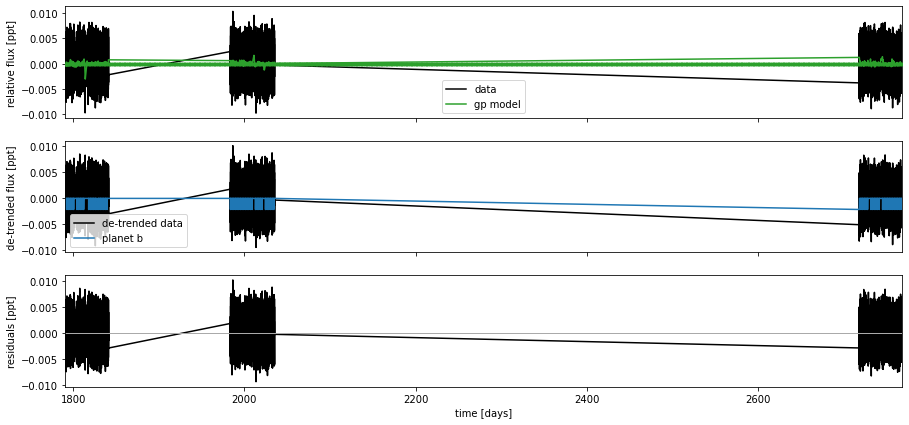

In [16]:
%matplotlib inline
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(15, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.plot(t, [0 for i in t], '.', color='C2', zorder=1000)
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    #ax.plot(t, [0 for i in t], '.', color='C0', zorder=1000)
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0, extras0)

In [17]:
#mod = (
#    extras0["gp_pred"]
#    + map_soln0["mean"]
#    + np.sum(extras0["light_curves"], axis=-1)
#)
#resid = y - mod
#rms = np.sqrt(np.median(resid**2))
#mask = np.abs(resid) < 7 * rms

#plt.figure(figsize=(10, 5))
#plt.plot(x, resid, "k", label="data")
#plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
#plt.axhline(0, color="#aaaaaa", lw=1)
#plt.ylabel("residuals [ppt]")
#plt.xlabel("time [days]")
#plt.legend(fontsize=12, loc=3)
#_ = plt.xlim(x.min(), x.max())

In [18]:
#model, map_soln, extras = build_model(mask, map_soln0)
#_ = plot_light_curve(map_soln, extras, mask)

In [19]:
with model0:
    trace = pm.sample(
        tune=500,
        draws=1000,
        start=map_soln0,
        cores=1,
        chains=2,
        #target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, u_star, mean]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 6477 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6639229862450359, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [20]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        #"r_star",
        #"m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.765,1.519,-2.847,3.023,0.222,0.173,50.0,159.0,1.02
ecc,0.224,0.142,0.000,0.468,0.015,0.011,94.0,186.0,1.01
r_pl,0.011,0.000,0.010,0.011,0.000,0.000,24.0,25.0,1.07
b,0.480,0.219,0.073,0.771,0.032,0.028,26.0,23.0,1.06
t0,1786.754,0.000,1786.754,1786.755,0.000,0.000,119.0,555.0,1.03
period,1.950,0.000,1.950,1.950,0.000,0.000,101.0,247.0,1.02
u_star[0],0.445,0.238,0.028,0.838,0.020,0.014,131.0,136.0,1.05
u_star[1],0.145,0.315,-0.435,0.686,0.020,0.014,287.0,340.0,1.03
mean,0.000,0.000,-0.000,0.000,0.000,0.000,207.0,106.0,1.02


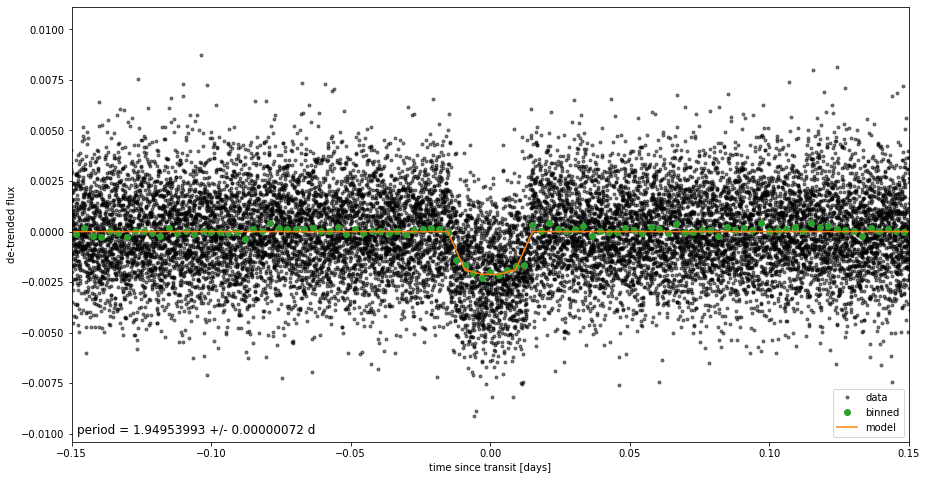

In [21]:
%matplotlib inline
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras0["gp_pred"] + map_soln0["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
plt.figure(figsize=(15, 8))
x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y - gp_mod, ".k", alpha=0.5, label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.15, 0.15, 100)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.8f} +/- {1:.8f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

In [22]:
print("Period:")
print("    ", np.median(flat_samps["period"]), '+/-', np.std(flat_samps["period"]))
print("T0:")
print("    ", np.median(flat_samps["t0"])+2457000, '+/-', np.std(flat_samps["t0"]))
print("ecc:")
print("    ", np.median(flat_samps["ecc"]), '+/-', np.std(flat_samps["ecc"]))

Period:
     1.9495399536329527 +/- <xarray.DataArray 'period' ()>
array(7.20857144e-07)
T0:
     2458786.7541418825 +/- <xarray.DataArray 't0' ()>
array(0.00021236)
ecc:
     0.22016918960800655 +/- <xarray.DataArray 'ecc' ()>
array(0.14166542)


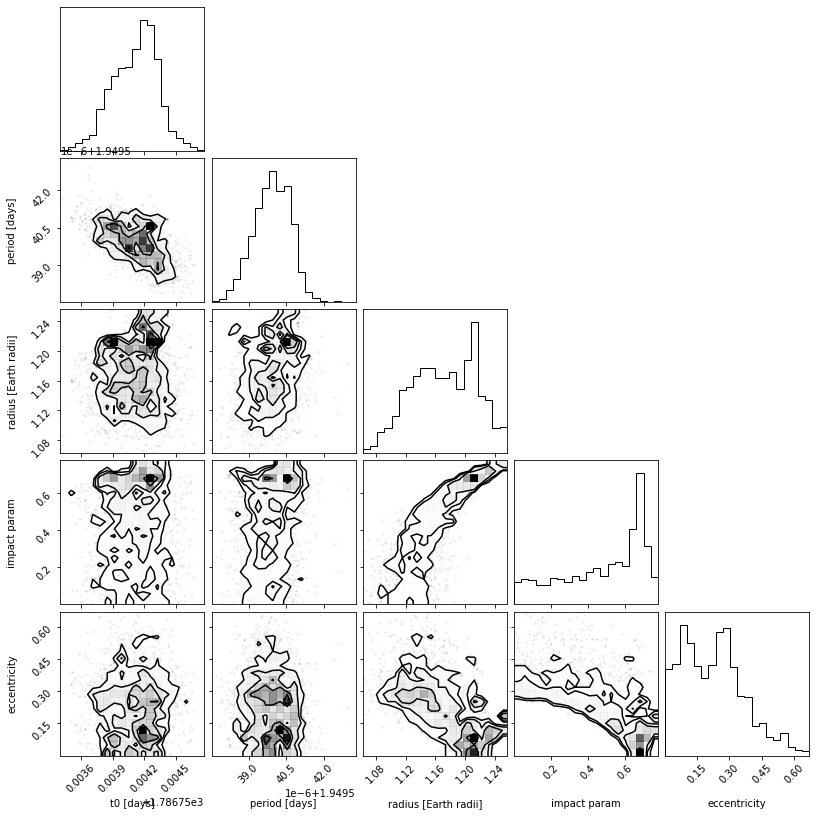

In [23]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["t0", "period", "r_earth", "b", "ecc"],
    labels=[
        "t0 [days]",
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)

In [24]:
transit_table = Table()
transit_table['time'] = x+2457000
transit_table['flux'] = y - gp_mod + 1
transit_table['error'] = np.array([np.std(y-gp_mod) for i in y])

ascii.write(transit_table, 
            f'../Solve_Systems/{hostname.replace(" ", "")}/{hostname.replace(" ", "")}.TESS.Sector{sector_numbers[sector_ind_start]}-{sector_numbers[sector_ind_end-1]}.dat', 
            names=('#time', 'flux', 'error'), 
            overwrite=True)  

In [25]:
np.array([np.std(y-gp_mod) for i in y])

array([0.00207124, 0.00207124, 0.00207124, ..., 0.00207124, 0.00207124,
       0.00207124])